In [ ]:
!pip install scikit-multilearn
!pip install scikit-multilearn --upgrade

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import nltk
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset

from google.colab import drive
drive.mount('/content/drive')

Requirement already up-to-date: scikit-multilearn in /usr/local/lib/python3.7/dist-packages (0.2.0)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.9315761979999877
GPU (s):
0.043328268999999864
GPU speedup over CPU: 67x


##Data Source Path

In [ ]:
text_path='/content/drive/MyDrive/colab_SMAI/test1.txt'

1246166 record full

In [ ]:
df=pd.read_csv(text_path, names=['Id', 'Title','Body','Tag'],skiprows=1,nrows=300000)

In [ ]:
print("Columns-index in data set : "+ str(df.columns))
print("Total Records: "+ str(len(df)))
print("Number of records with null TAG field: "+str(df['Tag'].isnull().sum(axis = 0)))
print("\n--------------Example Sample Data:-----------------" )
print(df.tail())

Columns-index in data set : Index(['Id', 'Title', 'Body', 'Tag'], dtype='object')
Total Records: 300000
Number of records with null TAG field: 0

--------------Example Sample Data:-----------------
            Id  ...                          Tag
299995  299996  ...                     java c++
299996  299997  ...              java atmosphere
299997  299998  ...                     captions
299998  299999  ...  android google-maps map gps
299999  300000  ...          php html paypal-ipn

[5 rows x 4 columns]


null handle

In [ ]:
df['Tag'] = df['Tag'].fillna("")
df['Tag'] = df['Tag'].astype(str)

In [ ]:
# adding a new feature number of tags per question
df["Tag_count"] = df["Tag"].apply(lambda text: len(text.split(" ")))

In [ ]:
df.Tag_count

0         5
1         1
2         3
3         3
4         3
         ..
299995    2
299996    2
299997    1
299998    4
299999    3
Name: Tag_count, Length: 300000, dtype: int64

In [ ]:
df['cleaned_tags']=df['Tag'].str.lower().replace('\n','')
df['cleaned_tags']=df['cleaned_tags'].apply(lambda x: str(x).encode('ascii', 'ignore').decode('ascii'))
df['cleaned_tags']=df['cleaned_tags'].str.replace('\d+', '')
df['cleaned_tags']=df['cleaned_tags'].str.replace(' +', ' ')

junk_chars = "[]{}.-"
for c in junk_chars:
  df['cleaned_tags']=df['cleaned_tags'].str.replace(c, '')


In [ ]:
df[90:100]

,Id,Title,Body,Tag,Tag_count,cleaned_tags
90,91,F# working with while loop,<p>I have a datareader and i want to return co...,f#,1,f#
91,92,showing newly added rows after submit if error...,<p>I am using this Javascript to add rows in t...,php javascript html,3,php javascript html
92,93,jQuery Masonry access internal method var,<p>Any advice how to access an internal method...,jquery,1,jquery
93,94,Java 2Dimensional Boolean Array Values,<p>I'm having a problem with my 2 dimensional ...,java multidimensional-array boolean,3,java multidimensionalarray boolean
94,95,failed to open stream : Is a directory in,<p>I am getting the following warnings on tryi...,php file-upload warnings,3,php fileupload warnings
95,96,why *foo ++= *++foo may be undefined?,<p>it should set the current character to next...,c pointers gcc,3,c pointers gcc
96,97,Performance when using document() repeatedly i...,<p>Is it acceptable to call the same document ...,xslt,1,xslt
97,98,How can I find out if my GNU C library is thre...,"<p>I'm currently <a href=""http://www.mathworks...",c matlab thread-safety mex,4,c matlab threadsafety mex
98,99,JSP link submitting data to struts form bean,<p>I am making a JSP page that links to a page...,jsp struts-1,2,jsp struts
99,100,Limit of a function satisfying an inequality,<p>If $f(x)+f(y)\leq f(x+y)$ and $f:\mathbb{R}...,calculus inequality limit functional-equations,4,calculus inequality limit functionalequations


In [ ]:
print( "Maximum number of tags in a question: ", df["Tag_count"].max())
print( "Minimum number of tags in a question: ", df["Tag_count"].min())
print( "Average number of tags in a question: ", df["Tag_count"].mean())

Maximum number of tags in a question:  5
Minimum number of tags in a question:  1
Average number of tags in a question:  2.88705


Text(0, 0.5, 'Frequency')

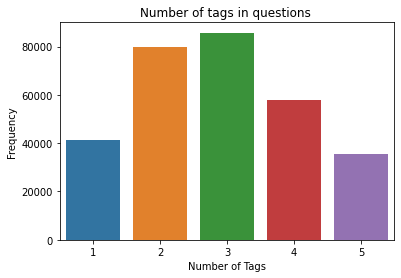

In [ ]:
sns.countplot(df["Tag_count"])
plt.title("Number of tags in questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Frequency")

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_bow = vectorizer.fit_transform(df['cleaned_tags'])

In [ ]:
data=df.drop(columns=['Tag'])
level=df.drop(columns=['Id', 'Title','Body'])

In [ ]:
print("Number of QnA :", tag_bow.shape[0])
print("Number of unique tags :", tag_bow.shape[1])

Number of QnA : 300000
Number of unique tags : 25118


In [ ]:
tags = vectorizer.get_feature_names()
print("Few tags :", tags[:20])

Few tags : ['a', 'aaa', 'aaasyntax', 'aabb', 'aac', 'aac+', 'aapt', 'aasm', 'ab', 'abaddressbook', 'abaddressbooksource', 'abandonedmutexexception', 'abandonware', 'abap', 'abbreviation', 'abbyy', 'abc', 'abcl', 'abcpdf', 'abeliancategories']


In [ ]:
freq = tag_bow.sum(axis=0).A1
tag_to_count_map = dict(zip(tags, freq))

In [ ]:
print(tag_to_count_map)

{'a': 3, 'aaa': 1, 'aaasyntax': 1, 'aabb': 1, 'aac': 18, 'aac+': 1, 'aapt': 4, 'aasm': 2, 'ab': 2, 'abaddressbook': 10, 'abaddressbooksource': 1, 'abandonedmutexexception': 1, 'abandonware': 1, 'abap': 25, 'abbreviation': 3, 'abbyy': 3, 'abc': 3, 'abcl': 1, 'abcpdf': 7, 'abeliancategories': 4, 'abeliangroups': 23, 'abelianvarieties': 3, 'aberration': 3, 'abi': 8, 'abinitio': 1, 'abiogenesis': 1, 'abletonlive': 2, 'abort': 11, 'abortion': 2, 'aboutbox': 2, 'aboutconfig': 4, 'abpeoplepickerview': 4, 'abpersonviewcontroller': 3, 'abrecord': 1, 'abrecordref': 3, 'absolute': 17, 'absolutelayout': 2, 'absolutepath': 14, 'absolutepositioning': 41, 'absolutevalue': 11, 'abstract': 38, 'abstractalgebra': 552, 'abstractbaseclass': 1, 'abstractclass': 73, 'abstractdatatype': 2, 'abstractfactory': 4, 'abstraction': 20, 'abstractmethods': 3, 'abstractsyntaxtree': 11, 'abstracttablemodel': 7, 'abstracttype': 2, 'abtest': 1, 'abtesting': 5, 'abuse': 1, 'ac': 1, 'acaccount': 2, 'acadapter': 2, 'acc': 

In [ ]:
l = []
for key, value in tag_to_count_map.items():
  l.append([key, value])

In [ ]:
tag_df = pd.DataFrame(l, columns=['Tags', 'Counts'])

Text(0, 0.5, 'Frequency')

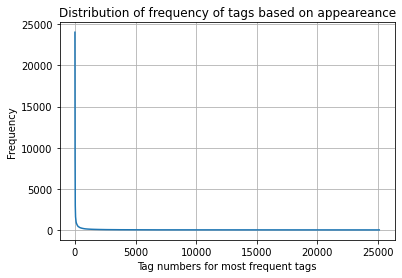

In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

In [ ]:
tag_df_sorted[0:10]

,Tags,Counts
2573,c#,24039
10820,java,20534
16219,php,19819
10858,javascript,18209
628,android,16007
11146,jquery,14897
2576,c++,10220
9567,html,9821
17329,python,9662
10584,iphone,9170


Text(0, 0.5, 'Frequency')

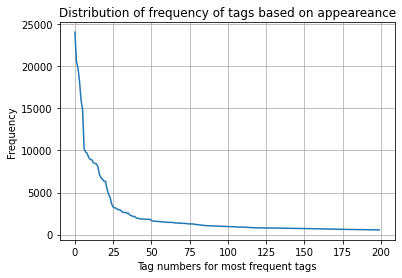

In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_df_sorted = tag_df_sorted[0:200]
plt.plot(tag_df_sorted['Counts'].values)
plt.grid()
plt.title("Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

In [ ]:
tag_df_sorted[0:10]

,Tags,Counts
2573,c#,24039
10820,java,20534
16219,php,19819
10858,javascript,18209
628,android,16007
11146,jquery,14897
2576,c++,10220
9567,html,9821
17329,python,9662
10584,iphone,9170


Text(0, 0.5, 'Frequency')

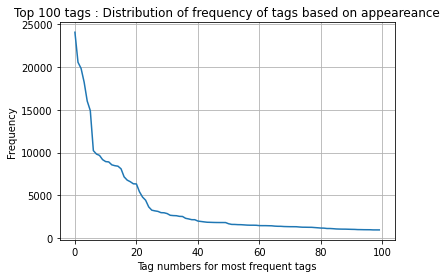

In [ ]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags : Distribution of frequency of tags based on appeareance")
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")

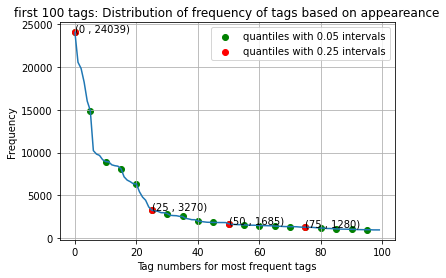

In [ ]:
plt.plot(tag_df_sorted['Counts'][0:100].values)
plt.scatter(x=np.arange(0,100,5), y=tag_df_sorted['Counts'][0:100:5], c='g', label="quantiles with 0.05 intervals")
plt.scatter(x=np.arange(0,100,25), y=tag_df_sorted['Counts'][0:100:25], c='r', label = "quantiles with 0.25 intervals")
for x,y in zip(np.arange(0,100,25), tag_df_sorted['Counts'][0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.01, y+30))

plt.title('first 100 tags: Distribution of frequency of tags based on appeareance')
plt.grid()
plt.xlabel("Tag numbers for most frequent tags")
plt.ylabel("Frequency")
plt.legend()

In [ ]:
print("{} tags are used more than 30000 times".format(tag_df_sorted[tag_df_sorted["Counts"]>10000].shape[0]))
print("{} tags are used more than 10000 times".format(tag_df_sorted[tag_df_sorted["Counts"]>5000].shape[0]))

7 tags are used more than 30000 times
22 tags are used more than 10000 times


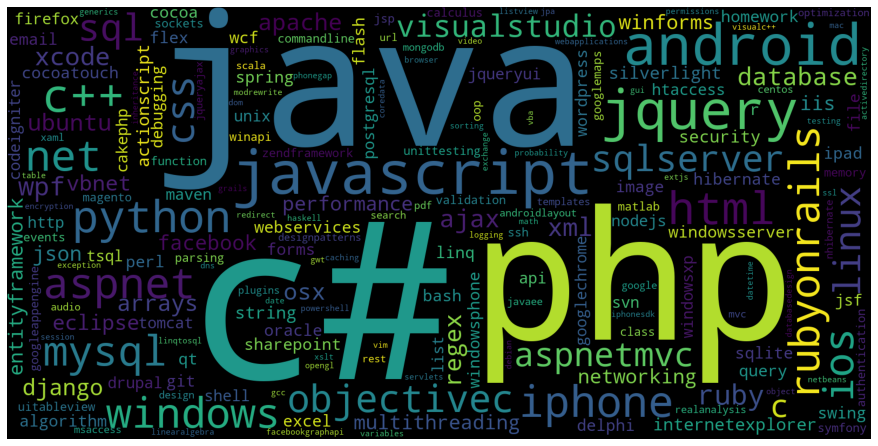

In [ ]:
tag_to_count_map
tupl = dict(tag_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

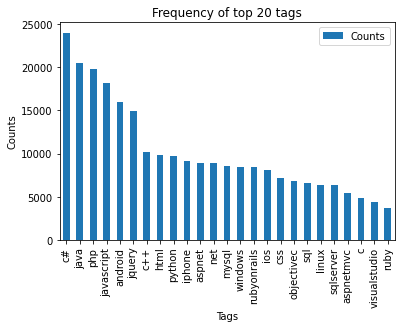

In [ ]:
i=np.arange(25)
tag_df_sorted.head(25).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [ ]:
df.columns

Index(['Id', 'Title', 'Body', 'Tag', 'Tag_count', 'cleaned_tags'], dtype='object')

In [ ]:
import nltk
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
qus_list=[]
qus_with_code = 0
len_before_preprocessing = 0 
len_after_preprocessing = 0 
cnt = 0
for index,row in df.iterrows():
    title, body, tags = row["Title"], row["Body"], row["cleaned_tags"]
    if '<code>' in body:
        qus_with_code+=1
    len_before_preprocessing+=len(title) + len(body)
    body=re.sub('<code>(.*?)</code>', '', body, flags=re.MULTILINE|re.DOTALL)
    body = re.sub('<.*?>', ' ', str(body.encode('utf-8')))
    title=title.encode('utf-8')
    question=str(title)+" "+str(body)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    qus_list.append(question)
    len_after_preprocessing += len(question)
    cnt = cnt + 1
    if (cnt%25000 == 0):
      print("processed : ", cnt)

df["question"] = qus_list
avg_len_before_preprocessing=(len_before_preprocessing*1.0)/df.shape[0]
avg_len_after_preprocessing=(len_after_preprocessing*1.0)/df.shape[0]
print( "Avg. length of questions(Title+Body) before preprocessing: ", avg_len_before_preprocessing)
print( "Avg. length of questions(Title+Body) after preprocessing: ", avg_len_after_preprocessing)
print ("% of questions containing code: ", (qus_with_code*100.0)/df.shape[0])

processed :  25000
processed :  50000
processed :  75000
processed :  100000
processed :  125000
processed :  150000
processed :  175000
processed :  200000
processed :  225000
processed :  250000
processed :  275000
processed :  300000
Avg. length of questions(Title+Body) before preprocessing:  1148.74996
Avg. length of questions(Title+Body) after preprocessing:  327.98059
% of questions containing code:  56.14633333333333


In [ ]:
df.question

0         check upload file imag without mime type like ...
1         prevent firefox close press ctrl favorit edito...
2         error invalid type list variabl import matlab ...
3         replac special charact url probabl simpl simpl...
4         modifi whoi contact detail use modifi function...
                                ...                        
299995    automat java c convers anyon tri automat java ...
299996    generat server side event atmospher hard time ...
299997    remov figur pictur search web luck ni two pict...
299998    current user locat retriev last question gps g...
299999    paypal nightmar includ exampl tri test sinc ne...
Name: question, Length: 300000, dtype: object

In [ ]:
preprocessed_df = df[["question","cleaned_tags"]]
print("Shape of preprocessed data :", preprocessed_df.shape)

Shape of preprocessed data : (300000, 2)


In [ ]:
preprocessed_df[:10]

,question,cleaned_tags
0,check upload file imag without mime type like ...,php imageprocessing fileupload upload mimetypes
1,prevent firefox close press ctrl favorit edito...,firefox
2,error invalid type list variabl import matlab ...,r matlab machinelearning
3,replac special charact url probabl simpl simpl...,c# url encoding
4,modifi whoi contact detail use modifi function...,php api filegetcontents
5,set proxi activ directori environ use machin a...,proxy activedirectory jmeter
6,draw barplot way coreplot imag post link pictu...,coreplot
7,fetch xml feed use asp net decid convert windo...,c# aspnet windowsphone
8,net librari generat javascript know net librar...,net javascript codegeneration
9,sql server procedur call inlin concaten imposs...,sql variables parameters procedure calls


In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
y_multilabel = vectorizer.fit_transform(preprocessed_df['cleaned_tags'])

In [ ]:
def tags_to_consider(n):
    tag_i_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tag_i_sum)), key=lambda i: tag_i_sum[i], reverse=True)
    yn_multilabel=y_multilabel[:,sorted_tags_i[:n]]
    return yn_multilabel

def questions_covered_fn(numb):
    yn_multilabel = tags_to_consider(numb)
    x= yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x==0))

In [ ]:
questions_covered = []
total_tags=y_multilabel.shape[1]
total_qus=preprocessed_df.shape[0]
for i in range(100, total_tags, 100):
    questions_covered.append(np.round(((total_qus-questions_covered_fn(i))/total_qus)*100,3))

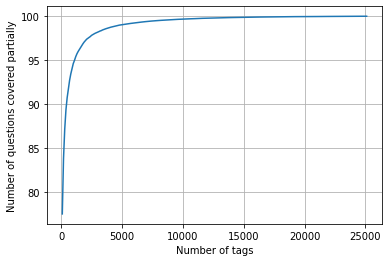

94.601 % of questions covered by 1000 tags
Number of questions that are not covered by 100 tags :  16196 out of  300000


In [ ]:
plt.plot(np.arange(100,total_tags, 100),questions_covered)
plt.xlabel("Number of tags")
plt.ylabel("Number of questions covered partially")
plt.grid()
plt.show()
print(questions_covered[9],"% of questions covered by 1000 tags")
print("Number of questions that are not covered by 100 tags : ", questions_covered_fn(1000),"out of ", total_qus)

In [ ]:
yx_multilabel = tags_to_consider(100)
print("Number of tags in the subset :", y_multilabel.shape[1])
print("Number of tags considered :", yx_multilabel.shape[1],"(",(yx_multilabel.shape[1]/y_multilabel.shape[1])*100,"%)")

Number of tags in the subset : 25118
Number of tags considered : 100 ( 0.398120869495979 %)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df, yx_multilabel, test_size = 0.2,random_state = 42)
print("Number of data points in training data :", X_train.shape[0])
print("Number of data points in test data :", X_test.shape[0])

Number of data points in training data : 240000
Number of data points in test data : 60000


In [ ]:
type(X_train)
type(y_train)

scipy.sparse.csr.csr_matrix

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=20000, tokenizer = lambda x: x.split(), ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train['question'])
X_test_multilabel = vectorizer.transform(X_test['question'])

In [ ]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train_multilabel, y_train)
y_pred = clf.predict(X_test_multilabel)

In [ ]:
print(X_train_multilabel.shape)
print(X_test_multilabel.shape)
print(y_train.shape)
print(y_pred.shape)

(240000, 20000)
(60000, 20000)
(240000, 100)
(60000, 100)


In [ ]:
df.iloc[59939]

Id                                                          59940
Title           How to configure chainsaw bundle to view log4j...
Body            <p>I want to view my log4j log file in chainsa...
Tag                                                         log4j
Tag_count                                                       1
cleaned_tags                                                 logj
question        configur chainsaw bundl view log log file want...
Name: 59939, dtype: object

In [ ]:
print(y_pred[10])
print(y_test[10])


  (0, 13)	1
  (0, 13)	1


In [ ]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))
#print("Precision recall report :\n",metrics.classification_report(y_test, y_pred))

Accuracy : 0.3902
Macro f1 score : 0.39729039183169124
Micro f1 scoore : 0.48675273013847703
Hamming loss : 0.009117666666666666


In [ ]:
print("Precision recall report :\n",metrics.classification_report(y_test, y_pred))

Precision recall report :
               precision    recall  f1-score   support

           0       0.63      0.20      0.31      4752
           1       0.79      0.39      0.52      4046
           2       0.83      0.50      0.63      3996
           3       0.75      0.39      0.52      3660
           4       0.96      0.70      0.81      3215
           5       0.87      0.61      0.72      3032
           6       0.72      0.28      0.41      2001
           7       0.58      0.21      0.31      1897
           8       0.90      0.53      0.67      1928
           9       0.75      0.36      0.48      1816
          10       0.79      0.39      0.52      1745
          11       0.59      0.09      0.16      1722
          12       0.89      0.57      0.69      1800
          13       0.64      0.27      0.38      1610
          14       0.71      0.27      0.39      1513
          15       0.95      0.60      0.74      1365
          16       0.61      0.13      0.22      1326


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans

In [ ]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
np.random.seed(seed=11)

In [ ]:
clf_dummy = OneVsRestClassifier(DummyClassifier())
clf_dummy.fit(X_train_multilabel, y_train)
y_pred = clf_dummy.predict(X_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.06826666666666667
Macro f1 score : 0.01176287983375369
Micro f1 scoore : 0.030834431328868907
Hamming loss : 0.023783


In [ ]:
clf_sgd = OneVsRestClassifier(SGDClassifier())
clf_sgd.fit(X_train_multilabel, y_train)
y_pred = clf_sgd.predict(X_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.35695
Macro f1 score : 0.26209030919276916
Micro f1 scoore : 0.3925959348996316
Hamming loss : 0.0096475


In [ ]:
clf_lr = OneVsRestClassifier(LogisticRegression())
clf_lr.fit(X_train_multilabel, y_train)
y_pred = clf_lr.predict(X_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

KeyboardInterrupt: ignored

In [ ]:
clf_nb = OneVsRestClassifier(MultinomialNB())
clf_nb.fit(X_train_multilabel, y_train)
y_pred = clf_nb.predict(X_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

In [ ]:
clf_lsvc = OneVsRestClassifier(LinearSVC())
clf_lsvc.fit(X_train_multilabel, y_train)
y_pred = clf_lsvc.predict(X_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

In [ ]:
clf_pac = OneVsRestClassifier(PassiveAggressiveClassifier())
clf_pac.fit(X_train_multilabel, y_train)
y_pred = clf_pac.predict(X_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

In [ ]:
clf_perc = OneVsRestClassifier(Perceptron())
clf_perc.fit(X_train_multilabel, y_train)
y_pred = clf_perc.predict(X_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.3121833333333333
Macro f1 score : 0.47361689642732085
Micro f1 scoore : 0.5026839755703447
Hamming loss : 0.012105666666666667


In [ ]:
param_grid = {'estimator__C':[1,10,100,1000]}

In [ ]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10)
CV_svc.fit(X_train_multilabel, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... estimator__C=1, score=0.428, total= 1.4min
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] ...................... estimator__C=1, score=0.430, total= 1.4min
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s


[CV] ...................... estimator__C=1, score=0.427, total= 1.4min
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min remaining:    0.0s


[CV] ...................... estimator__C=1, score=0.428, total= 1.4min
[CV] estimator__C=1 ..................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.7min remaining:    0.0s


[CV] ...................... estimator__C=1, score=0.430, total= 1.4min
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.1min remaining:    0.0s


[CV] ..................... estimator__C=10, score=0.367, total= 3.5min
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.6min remaining:    0.0s


[CV] ..................... estimator__C=10, score=0.367, total= 3.1min
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 13.7min remaining:    0.0s


[CV] ..................... estimator__C=10, score=0.366, total= 3.2min
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 16.8min remaining:    0.0s


[CV] ..................... estimator__C=10, score=0.369, total= 3.2min
[CV] estimator__C=10 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 20.0min remaining:    0.0s


[CV] ..................... estimator__C=10, score=0.366, total= 3.2min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=0.298, total= 4.9min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=0.293, total= 5.0min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=0.295, total= 5.5min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=0.296, total= 5.3min
[CV] estimator__C=100 ................................................
[CV] .................... estimator__C=100, score=0.295, total= 5.2min
[CV] estimator__C=1000 ...............................................
[CV] ................... estimator__C=1000, score=0.274, total= 5.3min
[CV] estimator__C=1000 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 76.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                               class_weight=None,
                                                               dual=True,
                                                               fit_intercept=True,
                                                               intercept_scaling=1,
                                                               loss='squared_hinge',
                                                               max_iter=1000,
                                                               multi_class='ovr',
                                                               penalty='l2',
                                                               random_state=None,
                                                               tol=0.0001,
                                                               verbose=0),
                 

In [ ]:
CV_svc.best_params_

{'estimator__C': 1}

In [ ]:
best_model = CV_svc.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test_multilabel)

In [ ]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.43111666666666665
Macro f1 score : 0.5079601950300919
Micro f1 scoore : 0.5689081338087961
Hamming loss : 0.008462333333333334


In [ ]:
param_grid = {'estimator__C':[.5,.7,.8,.9,1]}
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10)
CV_svc.fit(X_train_multilabel, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] estimator__C=0.5 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... estimator__C=0.5, score=0.429, total= 1.1min
[CV] estimator__C=0.5 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] .................... estimator__C=0.5, score=0.432, total= 1.1min
[CV] estimator__C=0.5 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV] .................... estimator__C=0.5, score=0.430, total= 1.1min
[CV] estimator__C=0.5 ................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.3min remaining:    0.0s


[CV] .................... estimator__C=0.5, score=0.431, total= 1.1min
[CV] estimator__C=0.5 ................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.4min remaining:    0.0s


[CV] .................... estimator__C=0.5, score=0.431, total= 1.1min
[CV] estimator__C=0.7 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s


[CV] .................... estimator__C=0.7, score=0.430, total= 1.2min
[CV] estimator__C=0.7 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.7min remaining:    0.0s


[CV] .................... estimator__C=0.7, score=0.432, total= 1.2min
[CV] estimator__C=0.7 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.8min remaining:    0.0s


[CV] .................... estimator__C=0.7, score=0.429, total= 1.2min
[CV] estimator__C=0.7 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.0min remaining:    0.0s


[CV] .................... estimator__C=0.7, score=0.431, total= 1.2min
[CV] estimator__C=0.7 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 10.2min remaining:    0.0s


[CV] .................... estimator__C=0.7, score=0.432, total= 1.2min
[CV] estimator__C=0.8 ................................................
[CV] .................... estimator__C=0.8, score=0.429, total= 1.2min
[CV] estimator__C=0.8 ................................................
[CV] .................... estimator__C=0.8, score=0.432, total= 1.3min
[CV] estimator__C=0.8 ................................................
[CV] .................... estimator__C=0.8, score=0.429, total= 1.2min
[CV] estimator__C=0.8 ................................................
[CV] .................... estimator__C=0.8, score=0.430, total= 1.2min
[CV] estimator__C=0.8 ................................................
[CV] .................... estimator__C=0.8, score=0.431, total= 1.2min
[CV] estimator__C=0.9 ................................................
[CV] .................... estimator__C=0.9, score=0.428, total= 1.3min
[CV] estimator__C=0.9 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 30.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                               class_weight=None,
                                                               dual=True,
                                                               fit_intercept=True,
                                                               intercept_scaling=1,
                                                               loss='squared_hinge',
                                                               max_iter=1000,
                                                               multi_class='ovr',
                                                               penalty='l2',
                                                               random_state=None,
                                                               tol=0.0001,
                                                               verbose=0),
                 

In [ ]:
CV_svc.best_params_

{'estimator__C': 0.7}

In [ ]:
best_model = CV_svc.best_estimator_
y_pred = best_model.predict(X_test_multilabel)

In [ ]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.4323
Macro f1 score : 0.5014626431845373
Micro f1 scoore : 0.5661736268080755
Hamming loss : 0.008412833333333333


In [ ]:
param_grid = {'estimator__C':[.25,.3,.5,.65,.7,.75,1]}
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10)
CV_svc.fit(X_train_multilabel, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] estimator__C=0.25 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... estimator__C=0.25, score=0.426, total= 1.0min
[CV] estimator__C=0.25 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV] ................... estimator__C=0.25, score=0.428, total=  59.7s
[CV] estimator__C=0.25 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


[CV] ................... estimator__C=0.25, score=0.426, total=  59.4s
[CV] estimator__C=0.25 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


[CV] ................... estimator__C=0.25, score=0.426, total= 1.0min
[CV] estimator__C=0.25 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.0min remaining:    0.0s


[CV] ................... estimator__C=0.25, score=0.428, total=  59.6s
[CV] estimator__C=0.3 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.0min remaining:    0.0s


[CV] .................... estimator__C=0.3, score=0.427, total= 1.0min
[CV] estimator__C=0.3 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.0min remaining:    0.0s


[CV] .................... estimator__C=0.3, score=0.430, total= 1.0min
[CV] estimator__C=0.3 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  7.0min remaining:    0.0s


[CV] .................... estimator__C=0.3, score=0.428, total= 1.0min
[CV] estimator__C=0.3 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  8.1min remaining:    0.0s


[CV] .................... estimator__C=0.3, score=0.428, total= 1.0min
[CV] estimator__C=0.3 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  9.1min remaining:    0.0s


[CV] .................... estimator__C=0.3, score=0.429, total= 1.0min
[CV] estimator__C=0.5 ................................................
[CV] .................... estimator__C=0.5, score=0.429, total= 1.2min
[CV] estimator__C=0.5 ................................................
[CV] .................... estimator__C=0.5, score=0.432, total= 1.3min
[CV] estimator__C=0.5 ................................................
[CV] .................... estimator__C=0.5, score=0.430, total= 1.3min
[CV] estimator__C=0.5 ................................................
[CV] .................... estimator__C=0.5, score=0.431, total= 1.2min
[CV] estimator__C=0.5 ................................................
[CV] .................... estimator__C=0.5, score=0.431, total= 1.3min
[CV] estimator__C=0.65 ...............................................
[CV] ................... estimator__C=0.65, score=0.430, total= 1.3min
[CV] estimator__C=0.65 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 43.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=OneVsRestClassifier(estimator=LinearSVC(C=1.0,
                                                               class_weight=None,
                                                               dual=True,
                                                               fit_intercept=True,
                                                               intercept_scaling=1,
                                                               loss='squared_hinge',
                                                               max_iter=1000,
                                                               multi_class='ovr',
                                                               penalty='l2',
                                                               random_state=None,
                                                               tol=0.0001,
                                                               verbose=0),
                 

In [ ]:
CV_svc.best_params_

{'estimator__C': 0.7}

In [ ]:
best_model = CV_svc.best_estimator_
y_pred = best_model.predict(X_test_multilabel)

In [ ]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

NameError: ignored

In [ ]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [ ]:
dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
np.random.seed(seed=11)

In [ ]:
for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train_multilabel, y_train)
    y_pred = clf.predict(X_test_multilabel)
    print_score(y_pred, classifier)

Clf:  DummyClassifier


ValueError: ignored

In [ ]:
print(y_pred)

  (0, 1)	1
  (1, 2)	1
  (1, 12)	1
  (2, 63)	1
  (3, 9)	1
  (3, 14)	1
  (3, 28)	1
  (5, 17)	1
  (6, 15)	1
  (8, 3)	1
  (10, 13)	1
  (16, 59)	1
  (20, 4)	1
  (21, 1)	1
  (25, 5)	1
  (26, 44)	1
  (29, 15)	1
  (30, 2)	1
  (31, 2)	1
  (33, 24)	1
  (35, 5)	1
  (37, 1)	1
  (37, 2)	1
  (37, 34)	1
  (39, 42)	1
  :	:
  (59939, 6)	1
  (59939, 80)	1
  (59941, 8)	1
  (59945, 19)	1
  (59948, 48)	1
  (59956, 4)	1
  (59957, 9)	1
  (59957, 12)	1
  (59958, 0)	1
  (59958, 6)	1
  (59962, 57)	1
  (59965, 8)	1
  (59966, 14)	1
  (59975, 6)	1
  (59975, 8)	1
  (59975, 22)	1
  (59977, 36)	1
  (59986, 2)	1
  (59987, 17)	1
  (59989, 7)	1
  (59993, 1)	1
  (59993, 20)	1
  (59995, 21)	1
  (59997, 21)	1
  (59998, 15)	1


In [ ]:
print("Training data shape X : ",X_train_multilabel.shape, "Y :",y_train.shape)
print("Test data shape X : ",X_test_multilabel.shape,"Y:",y_test.shape)

Training data shape X :  (240000, 20000) Y : (240000, 100)
Test data shape X :  (60000, 20000) Y: (60000, 100)


In [ ]:
df22=df.groupby('Id')['Tag'].apply(str)

In [ ]:
grouped_tags = df.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [ ]:
grouped_tags.head(100)

Id
1      php image-processing file-upload upload mime-t...
2                                                firefox
3                              r matlab machine-learning
4                                        c# url encoding
5                              php api file-get-contents
                             ...                        
96                                        c pointers gcc
97                                                  xslt
98                            c matlab thread-safety mex
99                                          jsp struts-1
100       calculus inequality limit functional-equations
Name: Tag, Length: 100, dtype: object

In [ ]:
grouped_tags.reset_index()

,Id,Tag
0,1,php image-processing file-upload upload mime-t...
1,2,firefox
2,3,r matlab machine-learning
3,4,c# url encoding
4,5,php api file-get-contents
...,...,...
299995,299996,java c++
299996,299997,java atmosphere
299997,299998,captions
299998,299999,android google-maps map gps


In [ ]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [ ]:
grouped_tags_final.head()

,Id,Tags
0,1,php image-processing file-upload upload mime-t...
1,2,firefox
2,3,r matlab machine-learning
3,4,c# url encoding
4,5,php api file-get-contents


In [ ]:
df1 = df

In [ ]:
df1.drop(columns=['Title', 'Body', 'Tag_count','Tag'], inplace=True)

KeyError: ignored

In [ ]:
df1.head()

,Id,cleaned_tags,question
0,1,php imageprocessing fileupload upload mimetypes,check upload file imag without mime type like ...
1,2,firefox,prevent firefox close press ctrl favorit edito...
2,3,r matlab machinelearning,error invalid type list variabl import matlab ...
3,4,c# url encoding,replac special charact url probabl simpl simpl...
4,5,php api filegetcontents,modifi whoi contact detail use modifi function...


In [ ]:
df2 = df1.merge(grouped_tags_final, on='Id')

In [ ]:
df2.head()

,Id,cleaned_tags,question,Tags
0,1,php imageprocessing fileupload upload mimetypes,check upload file imag without mime type like ...,php image-processing file-upload upload mime-t...
1,2,firefox,prevent firefox close press ctrl favorit edito...,firefox
2,3,r matlab machinelearning,error invalid type list variabl import matlab ...,r matlab machine-learning
3,4,c# url encoding,replac special charact url probabl simpl simpl...,c# url encoding
4,5,php api filegetcontents,modifi whoi contact detail use modifi function...,php api file-get-contents


In [ ]:

#df22=df2.groupby('Id')['Tag'].apply(lambda x: ','.join(str(x)))

df23=df22.to_frame()

df23.reset_index(level=0, inplace=True)
#df23['Id']=df23.index

#####Merge 2 Dataframe

In [ ]:
df3 = pd.merge(df11, df23, on='Id')

NameError: ignored

In [ ]:
df3['cleaned_tags'] = df3['Tag']

NameError: ignored

In [ ]:
df3.head()

In [ ]:
train=df3
train['cleaned_tags']=train['cleaned_tags'].str.replace('\n','')
train['cleaned_tags']=train['cleaned_tags'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
train['cleaned_tags']=train['cleaned_tags'].str.replace('\d+', '')
train['cleaned_tags']=train['cleaned_tags'].str.replace(' +', ' ')
junk_chars = "[]{}"
for c in junk_chars:
  train['cleaned_tags']=train['cleaned_tags'].str.replace(c, '')


NameError: ignored

In [ ]:
train['cleaned_tags'].head()

In [ ]:
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    df3.to_sql('data', disk_engine)

NameError: ignored

In [ ]:
if os.path.isfile('train.db'):
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()

In [ ]:
#Dont Run TOO Big
disk_engine.execute("SELECT * FROM data").fetchall()

##VISUALIZATION

In [ ]:
train.head()

In [ ]:
##Creating the target dataframe(as its a multilabel problem)  -----dont execute RAM crashed
pd.options.display.max_columns = 10
#dummy = df3['cleaned_tags'].str.get_dummies(' ')
print("The number of unique tags are {}".format(dummy.shape[1]))
dummy.head()

In [ ]:
##Lets check the distribution of each tags 
tot_tags = ' '.join(train['cleaned_tags'])
tot_tags = ','.join(tot_tags.split())

In [ ]:
##Calling counter
from collections import Counter,OrderedDict
counting = Counter(tot_tags.split(','))
count_dict = OrderedDict(counting.most_common(50))

In [ ]:
##getting the keys and values
key = []
vals = []
for i,j in zip(count_dict.keys(),count_dict.values()):
    key.append(i)
    vals.append(j)
    
plt.figure(figsize = (16,6))
sns.set(color_codes = True)
sns.barplot(x = key,y = vals)
plt.xticks(rotation = 90)
plt.xlabel('tags')
plt.ylabel('frequency')
plt.title("Distributon of MOST COMMON TAGS UNSED(50)")

In [ ]:
#tag_words = ' '.join([word for word in train['clean_tags'][train['labels'] == 0]])
#text = data.Tweet.values
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(tot_tags)
print('Tag words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
##Necessary imports
import seaborn as sns
import nltk
import multiprocessing
import re
import os
import json
import gensim.models.word2vec as w2v
import sklearn.manifold as mf
import tensorflow as tf

In [ ]:
##Preparing the text corpus
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

train['new_title'] = train['Title'].apply(lambda x: clean_text(x))
train['new_body'] = train['Body'].apply(lambda x: clean_text(x))

NameError: ignored

In [ ]:
##Tokenizing the words
train['new_title'] = train['new_title'].map(lambda z: z.split())
train['new_title'].head()

In [ ]:
##Defining the word2vec model

##HYPERPARAMETERS
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 4
downsampling = 1e-3
seed = 1

##Model definition
model2vec = w2v.Word2Vec(sg = 1,
                        seed = seed,
                        workers = num_workers,
                        size = num_features,
                        min_count = min_word_count,
                        window = context_size,
                        sample = downsampling)

##building the vocab

titles = list(train['new_title'])
model2vec.build_vocab(titles)

##Training the model
model2vec.train(titles,total_examples = model2vec.corpus_count,epochs = 100)

##saving the model
model2vec.save('embedding_index.bin')

In [ ]:
##Plotting using TSNE
tsne = mf.TSNE(n_components = 2,random_state = 0)
matrix = model2vec.wv.vectors
matrix_2d = tsne.fit_transform(matrix)

points = pd.DataFrame([(word,coords[0],coords[1]) 
                      for word,coords in [(word,matrix_2d[model2vec.wv.vocab[word].index])
                                         for word in model2vec.wv.vocab]],
                      columns = ['word','x','y'])

plt.figure(figsize = (16,6))
plt.scatter(points['x'],points['y'])

plt.title("Word Embeddings")

In [ ]:
##Loading the trained word2vec model
embedding = w2v.Word2Vec.load('embedding_index.bin')

In [ ]:
#dummy = train['cleaned_tags'].str.get_dummies(' ')
#print("The number of unique tags are {}".format(dummy.shape[1]))

In [ ]:
##Seperating the dataset
X = train['Title'].values
y = train['cleaned_tags'].values
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.10,random_state = 1001)
print("shape of X_train is {} and y_train is {}".format(X_train.shape,y_train.shape))
print("shape of X_test is {} and y_test is {}".format(X_test.shape,y_test.shape))

In [ ]:
##Loading the embedding
MAX_NB_WORDS = len(model2vec.wv.vocab)

##seq length got from "train['title'].map(lambda z: len(z.split())).mean()"
max_seq_length = 10

##text preprocessing
from keras.preprocessing.text import Tokenizer
max_words = 100000
##on train
tokenizer = Tokenizer(num_words = max_words,lower = True,oov_token = 'UNK')
tokenizer.fit_on_texts(X_train)
word_ids = tokenizer.word_index
print(word_ids)

##on test
tokenizer_test = Tokenizer(num_words = max_words,lower = True,oov_token = 'UNK')
tokenizer_test.fit_on_texts(X_test)
word_ids_test = tokenizer_test.word_index

In [ ]:
##converting the training data to the sequence of word indices:
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test  = tokenizer_test.texts_to_sequences(X_test)

In [ ]:
##padding the semtences so as to make them equal sized.
from keras.preprocessing.sequence import pad_sequences
text_data = pad_sequences(seq_train,max_seq_length,truncating="pre")
text_data_test = pad_sequences(seq_test,max_seq_length,truncating="pre")

In [ ]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, max_words)
word_vectors = model2vec.wv
# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
for word, i in word_ids.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass        

In [ ]:
##model building
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional, LSTM
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from tensorflow.python.compiler.tensorrt import trt_convert 

In [ ]:
!pip install tensorflow_estimator

In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,CuDNNLSTM,LSTM,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import normalize

In [ ]:
##initializing the embedding layer
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=max_seq_length,
                     trainable=False)

# Inputs
text_input = Input(shape=(max_seq_length,), dtype='int32')
embedded_sequences = wv_layer(text_input)

# biLSTM-1
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(32, return_sequences=False))(embedded_sequences)

# Dense-1
x2 = Dropout(0.2)(x)
x2 = BatchNormalization()(x2)
x2 = Dense(265, activation='relu')(x2)

# output
x3 = Dropout(0.2)(x2)
x3 = BatchNormalization()(x3)
pred = Dense(100,activation = 'sigmoid')(x3)


# build the model
model = Model(inputs=[text_input], outputs=pred)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=['accuracy'])

# getting the summary
model.summary()

In [ ]:
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    train.to_sql('data', disk_engine)

In [ ]:
if os.path.isfile('train.db'):
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()

In [ ]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tag, cleaned_tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tag,cleaned_tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

In [ ]:
#Dont Run TOO Big
disk_engine.execute("SELECT cleaned_tags FROM data").fetchall()

In [ ]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

In [ ]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

In [ ]:
train['cleaned_tags'].head()

In [ ]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["cleaned_tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df_no_dup["processed_tags"] = df_no_dup["cleaned_tags"].apply(lambda x: clean_text(x))


df_no_dup["processed_tags"]=df_no_dup["processed_tags"].str.replace('\n','')
df_no_dup["processed_tags"]=df_no_dup["processed_tags"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
df_no_dup["processed_tags"]=df_no_dup["processed_tags"].str.replace('\d+', '')
df_no_dup["processed_tags"]=df_no_dup["processed_tags"].str.replace(' +', ' ')
junk_chars = "[]{}:"
for c in junk_chars:
  df_no_dup["processed_tags"]=df_no_dup["processed_tags"].str.replace(c, '')

In [ ]:
df_no_dup.head()

In [ ]:
df_no_dup2=df_no_dup.drop(columns=['Tag','cleaned_tags'])
df_no_dup2.head()

In [ ]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup2.db'):
    disk_dup = create_engine("sqlite:///train_no_dup2.db")
    no_dup2 = pd.DataFrame(df_no_dup2, columns=['Title', 'Body','processed_tags'])
    no_dup2.to_sql('no_dup_train',disk_dup)

In [ ]:
no_dup2.head()

In [ ]:
disk_dup.execute("select processed_tags from no_dup_train")

In [ ]:
#creating the connection with database file.
if os.path.isfile('train_no_dup2.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup2.db')
    tag_data = pd.read_sql_query("""SELECT processed_tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

In [ ]:
tag_data['processed_tags'].head(100)

In [ ]:


# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['processed_tags'])

In [ ]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

In [ ]:


#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

In [ ]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [ ]:
#Saving this dictionary to csv files.
#if not os.path.isfile('tag_counts_dict_dtm.csv'):
with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
      writer = csv.writer(csv_file)
      for key, value in result.items():
          writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

In [ ]:
tag_df.head(100)

In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

In [ ]:
tag_df_sorted.head(10)

In [ ]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

In [ ]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
#print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

In [ ]:
plt.plot(tag_counts[0:100])
plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [ ]:
plt.plot(tag_counts[0:10])
plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10:5]), tag_counts[0:10:5])

In [ ]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [ ]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

In [ ]:
# Store tags greater than 500 in one list
lst_tags_gt_100 = tag_df[tag_df.Counts>100].Tags
#Print the length of the list
print ('{} Tags are used more than 100 times'.format(len(lst_tags_gt_100)))



# Store tags greater than 500 in one list
lst_tags_gt_500 = tag_df[tag_df.Counts>500].Tags
#Print the length of the list
print ('{} Tags are used more than 500 times'.format(len(lst_tags_gt_500)))

# Store tags greater than 1K in one list
lst_tags_gt_1k = tag_df[tag_df.Counts>1000].Tags
#Print the length of the list
print ('{} Tags are used more than 1000 times'.format(len(lst_tags_gt_1k)))

# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

In [ ]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

In [ ]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

In [ ]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

In [ ]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [ ]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

In [ ]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

In [ ]:


# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup2.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, processed_tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)



In [ ]:
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

In [ ]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:
preprocessed_data.head()

In [ ]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [ ]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [ ]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(100+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [ ]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

In [ ]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

In [ ]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [ ]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
#print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=2000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

In [ ]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)

In [ ]:
predictions = classifier.predict(x_test_multilabel)

In [ ]:
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
#print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

In [ ]:
print(predictions)

#####MODEL-2

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [ ]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")


In [ ]:


# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)



In [ ]:
train_datasize = 400000

In [ ]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]


In [ ]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.01, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
start = datetime.now()
from sklearn import svm
clf = svm.SVC(C=1,kernel='rbf',degree=5)
clf.fit(x_train_multilabel, y_train)

from sklearn import metrics
y_pred = clf.predict(x_train_multilabel)
print("Classification report for - \n{}:\n{}\n".format(clf, metrics.classification_report(y_test, y_pred)))

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

#print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

In [ ]:
def model_lr(x_train_tfidf, y_train,x_test_tfidf, y_test):
  print("------------LOG REG ----------")
  model_log = LogisticRegression()
  model_log.fit(x_train_tfidf,y_train)
  log_predictions = model_log.predict(x_test_tfidf)
  print('F1: ',f1_score(y_test,log_predictions))
  print('Accuracy :', accuracy_score(y_test,log_predictions))
  #print("confusion matrix:\n",confusion_matrix(y_test,log_predictions))

In [ ]:
def model_nb(x_train_tfidf, y_train,x_test_tfidf, y_test):
  print("------------NB ----------")
  from sklearn.naive_bayes import GaussianNB
  model_nb = GaussianNB()
  model_nb.fit(x_train_tfidf.todense(),y_train)
  nb_predictions = model_nb.predict(x_test_tfidf.todense())
  print('F1: ',f1_score(y_test,nb_predictions))
  print('Accuracy :', accuracy_score(y_test,nb_predictions))
  #print("confusion matrix:\n",confusion_matrix(y_test,nb_predictions))

In [ ]:
model_lr(x_train_multilabel, y_train,x_train_multilabel, y_test)

In [ ]:
model_nb(x_train_multilabel, y_train,x_train_multilabel, y_test)